### PlotBot
A bot that sends out visualized sentiment analysis of a Twitter account's recent tweets. The bot receives tweets via mentions and in turn performs sentiment analysis on the most recent twitter account specified in the mention.

For example, when a user tweets, "@alf7tf Analyze: @CNN," it will trigger a sentiment analysis on the CNN twitter feed.

A plot from the sentiment analysis is then tweeted to the @alf7tf twitter feed.

In [1]:
# Dependencies
import json
import tweepy
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time

# Import Twitter API Keys
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from textblob import TextBlob

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

### Scan for mentions

In [2]:
def scan(oldest_tweet):

    """
    Scan for mentions
    input:
        oldest_tweet - int, max_id used to filter the search
    output:
        target_account - str, target account name to pull tweets for sentiment analysis
        request - dict, dictionary of text, author, id, and time of the request
    """

    # Target Term
    my_account = "@alf7tf"
    search_term = f"{my_account} Analyze:"

    # Retrieve the most recent tweets
    public_tweets = api.search(search_term, count=1, result_type="recent", max_id=oldest_tweet)

    if len(public_tweets['statuses']) > 0:

        # Retrieve tweet text, author, id, and time
        tweet = public_tweets['statuses'][0]
        text = tweet['text']
        tweet_author = "@" + tweet["user"]["screen_name"]
        tweet_id = tweet['id']
        raw_time = tweet['created_at']
        datetime_time = datetime.datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
        request = {'text': text, 'author': tweet_author, 'id': tweet_id, 'time': datetime_time}
        
        # Identify account to analyze
        account_seperators = ':,;.!?'
        target_account = text.replace(search_term, "").strip(':,;.!?').strip()

        for seperator in account_seperators:
            if seperator in target_account:
                target_account = target_account.split(seperator)[0].strip()
        
    else:
        target_account = ''
        request = {}
        
    return target_account, request

### Pull 500 most recent tweets and analyze sentiment

In [3]:
def pull(target_account):
    
    """
    Pull 500 most recent tweets
    input:
        target_account - str, target account name to pull tweets for sentiment analysis
    output:
        tweets_data - list, list of the 500 tweets
    """
    
    # Create variable for holding the oldest tweet
    oldest_tweet = None
    tweets_data = []

    for x in range(5):
        
        # Get 100 tweets by the target user
        public_tweets = api.user_timeline(target_account, count=100, result_type="recent", max_id=oldest_tweet)
        tweets_data.extend(public_tweets)
        
        # Reassign the oldest tweet
        for tweet in public_tweets:
            tweet_id = tweet["id"]
            oldest_tweet = tweet_id - 1    
    
    return tweets_data

In [4]:
def analyze(tweets_data):

    """
    Analyze sentiment of tweets
    input:
        tweets_data - list, list of the 500 tweets
    output:
        df - DataFrame, dataframe that stores polarity score, tweet text, and # tweets ago
    """

    # Preallocate variables for analysis
    texts = []
    tweets_ago = []
    polarities = []
    counter = 0
    
    for tweet in tweets_data:
        
        # Retrieve tweet info
        text = tweet['text']
        
        # Run sentiment analysis
        testimonial = TextBlob(text)
        polarity = testimonial.sentiment.polarity

        # Store in list
        texts.append(text)
        tweets_ago.append(counter)
        polarities.append(polarity)
        
        counter -= 1
    
    # Write to dataframe
    df = pd.DataFrame({'text':texts, 'tweets ago':tweets_ago, 'polarity score':polarities})
    
    return df

### Plot sentiment over time

In [5]:
def plot(df, target_account):
    
    """
    Plot sentiment over time
    input:
        df - DataFrame, dataframe that stores polarity score, tweet text, and # tweets ago
        target_account - str, target account name to pull tweets for sentiment analysis
    output:
        fig_name - str, file name of the saved figure
    """
    
    mpl.rcParams['figure.dpi']= 100
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['Arial']
    sns.set(color_codes=True)
    today_date = datetime.date.today().strftime("%m/%d/%y")

    # Plot
    plt.plot(df["tweets ago"], df["polarity score"], label = target_account, marker = 'o', markersize = 6,
                color='steelblue', linewidth=0.5)

    # Format the plot
    fig_name = f'polarity_{target_account}.png'
    plt.yticks(np.arange(-1,1.5,0.5))
    plt.xlim((df['tweets ago'].min()-10, 10))
    plt.ylim((-1.05, 1.05))
    plt.xlabel('Tweets Ago')
    plt.ylabel('Tweet Polarity')
    plt.title(f'Sentiment Analysis of Tweets ({today_date})')
    plt.legend(loc='upper left', frameon=False, title='Tweets Source', bbox_to_anchor=[1,1])
    plt.savefig(fig_name, bbox_inches="tight", dpi = 300)
    None
    
    return fig_name

### Tweet out

In [6]:
def tweet_out(fig_name, target_account, request):
    
    """
    Create a twitter status update
    input:
        fig_name - str, file name of the saved figure
        target_account - str, target account name to pull tweets for sentiment analysis
        request - dict, dictionary of text, author, id, and time of the request
    output:
        status_output - status object
    """
    
    status = f"New Tweet Analysis: {target_account} (Thx {request['author']}!!)"
    status_output = api.update_with_media(filename = fig_name, status = status)

    return status_output

### Execute PlotBot


Request #1: @CNN analysis completed.
2018-06-03 18:18:40+00:00


KeyboardInterrupt: 

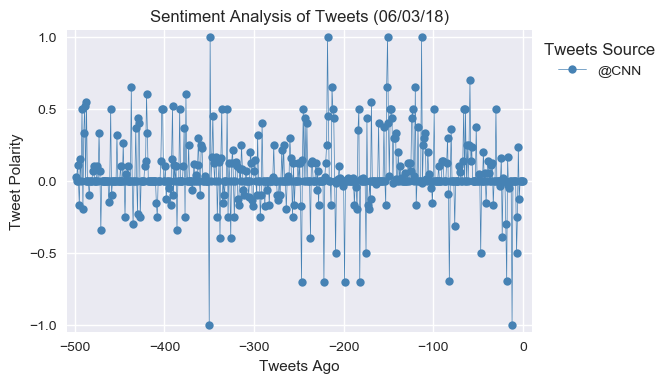

In [7]:
# Analyzed account names
account_analyzed = []
counter = 0
oldest_tweet = None

while counter < 10:
    
    # Scan for mention
    target_account, request = scan(oldest_tweet)
    oldest_tweet = request['id'] - 1 # Reassign so the previous oldest isn't included in the new search

    # If the target account is not empty and if the target account has not been analyzed
    if (len(target_account.strip('@')) > 0) & (target_account.lower() not in account_analyzed):
        
        # Append to the list of analyzed account names
        account_analyzed.append(target_account.lower())
            
        try: 
            
            # Pull tweets
            tweets_data = pull(target_account)
            
            # Analyze sentiment
            df = analyze(tweets_data)
            
            # Plot sentiment
            fig_name = plot(df, target_account)
            
            # Tweet out
            status_output = tweet_out(fig_name, target_account, request)

            # Successful execution
            counter += 1
            print(f"\nRequest #{counter}: {target_account} analysis completed.")
            print(f"{request['time']}")

        except:
            print(f"\nRequested account {target_account} does not exist.")
        
    # Wait 5 minutes before another scan
    time.sleep(5*60)
    
    